# Imports and setup

In [1]:
import velocycle as vc
from velocycle import *

In [51]:
# generic & ml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pyro
import copy
import scipy
import pycircstat
import pickle

# scRNA-seq
import scanpy as sc
import anndata

In [3]:
from threadpoolctl import threadpool_limits
threadpool_limits(limits=8)

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    print("Will use GPU")
    device = torch.device("cuda:0")
else:
    print("Will use CPU")
    device = torch.device("cpu")

Will use GPU


In [5]:
from datetime import datetime
current_datetime = datetime.now()
DATE = current_datetime.strftime("%d%m%Y")

In [6]:
CELL_DOT_COLOR = "#6A8E7F"
GENE_DOT_COLOR = "#71697A"

# Load and filter dataset

In [7]:
full_adatas = {   
    "fibroblasts": sc.read_h5ad("Data/capolupo_fibroblasts_cycling.h5ad")
}

In [8]:
# Filter lowly-expressed genes and concatenate all datasets
for a in full_adatas.keys(): 
    print(full_adatas[a].shape)
    sc.pp.filter_genes(full_adatas[a], min_cells=int((full_adatas[a].n_obs)*0.10))
    
data = anndata.concat(full_adatas, label="batch", join ="outer")

(1222, 32738)


In [9]:
# Perform some very basic gene filtering by unspliced counts
data = data[:, (data.layers["unspliced"].toarray().mean(0) > 0.1)].copy()

# Perform some very basic gene filtering by spliced counts
data = data[:, data.layers["spliced"].toarray().mean(0) > 0.3].copy()

In [10]:
# Create design matrix for dataset with a single batch
batch_design_matrix = preprocessing.make_design_matrix(data, ids="batch")

In [11]:
# Rough approximation of the cell cycle phase using categorical approaches 
sc.tl.score_genes_cell_cycle(data, s_genes=utils.S_genes_human, g2m_genes=utils.G2M_genes_human)

In [12]:
# Create size-normalized data layers
preprocessing.normalize_total(data)

In [13]:
# Get biologically-relevant gene set to use for velocity estimation
full_keep_genes = utils.get_cycling_gene_set(size="Large", species="Human")

# Initialize cycle and phase objects with priors

In [14]:
n_harm = 1
cycle_prior = cycle.Cycle.trivial_prior(gene_names=full_keep_genes, harmonics=n_harm)

In [15]:
# Keep only genes from biologically-relevant gene set that are present in current datasets
cycle_prior, data_to_fit = preprocessing.filter_shared_genes(cycle_prior, data, filter_type="intersection")

In [16]:
# Update the priors for gene harmonics
# to gene-specific means and stds
S = data_to_fit.layers['spliced'].toarray()
S_means = S.mean(axis=0) #sum over cells
nu0 = np.log(S_means)

if(n_harm==2): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0, 0*nu0, 0*nu0))
if(n_harm==1): S_frac_means=np.vstack((nu0, 0*nu0, 0*nu0))
if(n_harm==0): S_frac_means=nu0[None, :]
cycle_prior.set_means(S_frac_means)

nu0std = np.std(np.log(S+1), axis=0)/2
if(n_harm==2): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std, 0.2*nu0std, 0.2*nu0std))
if(n_harm==1): S_frac_stds=np.vstack((nu0std, 0.5*nu0std, 0.5*nu0std))
if(n_harm==0): S_frac_stds=nu0[None, :]
cycle_prior.set_stds(S_frac_stds)

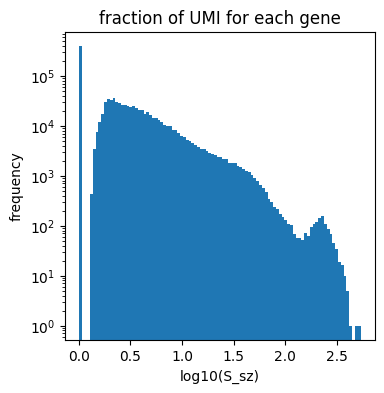

In [17]:
OFFSET=1
fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.set_title('fraction of UMI for each gene')
ax.hist(np.log10(data_to_fit.layers['S_sz'].flatten()+OFFSET), bins = 100)
ax.set_yscale("log")
ax.set_xlabel("log10(S_sz)")
ax.set_ylabel("frequency")
plt.show()

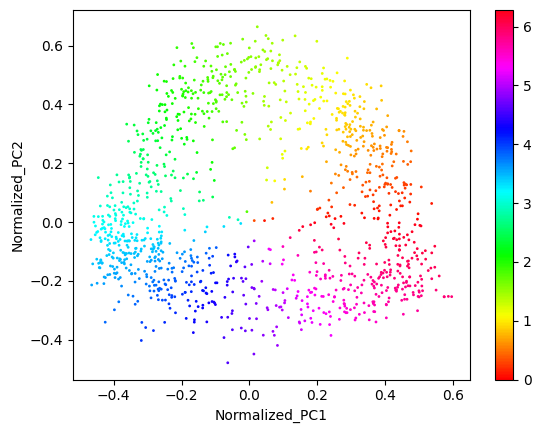

In [18]:
# Obtain a PCA prior for individual cell phases
data_to_fit.layers["S_sz_log"] = np.log(data_to_fit.layers["S_sz"]+1)
phase_prior = phases.Phases.from_pca_heuristic(data_to_fit, 
                                               genes_to_use=utils.get_cycling_gene_set(size="Small", species="Human"), 
                                               layer='S_sz_log',
                                               concentration=5.0, plot=True, small_count=OFFSET)

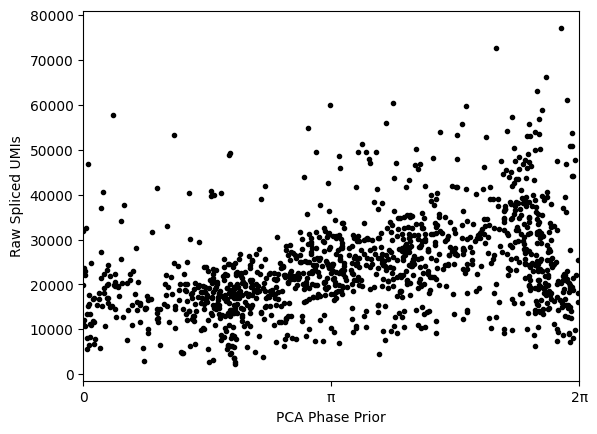

In [19]:
# Shift the phase prior to have maximum correlation with the total raw UMI counts
(shift, maxcor, allcor) = phase_prior.max_corr(data_to_fit.obs.n_scounts)
phase_prior.rotate(angle=-shift)
plt.plot(phase_prior.phis, data_to_fit.obs.n_scounts, '.', c='black')
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("PCA Phase Prior")
plt.ylabel("Raw Spliced UMIs")
plt.show()

# Run the manifold-learning module

In [20]:
pyro.clear_param_store()

In [21]:
# Set batch effect to zero because there is only a single dataset/batch
Δν = torch.zeros((batch_design_matrix.shape[1], S.shape[1], 1)).float().to(device)
condition_on_dict = {"Δν": Δν}

In [22]:
metapar = preprocessing.preprocess_for_phase_estimation(anndata=data_to_fit, 
                                          cycle_obj=cycle_prior, 
                                          phase_obj=phase_prior, 
                                          design_mtx=batch_design_matrix,
                                          normalize=False, 
                                          behavior="intersection", 
                                          noisemodel="NegativeBinomial", 
                                          gene_selection_model="all",
                                          n_harmonics=n_harm, 
                                          device = device,
                                          condition_on=condition_on_dict)

In [23]:
phase_fit = phase_inference_model.PhaseFitModel(metaparams=metapar, 
                                                condition_on=condition_on_dict,
                                                early_exit=False, num_samples=500, n_per_bin=50)
phase_fit.check_model()

 Trace Shapes:                               
  Param Sites:                               
 Sample Sites:                               
    cells dist              |                
         value         1222 |                
    genes dist              |                
         value          876 |                
  batches dist              |                
         value            1 |                
        ν dist     876    1 |    3           
         value     876    1 |    3           
       Δν dist   1 876    1 |                
         value   1 876    1 |                
      ϕxy dist         1222 |    2           
         value         1222 |    2           
        ϕ dist              | 1222           
         value              | 1222           
        ζ dist              | 1222 3         
         value              | 1222 3         
    ElogS dist              |    1 1 876 1222
         value              |    1 1 876 1222
shape_inv dist     876    1 |     

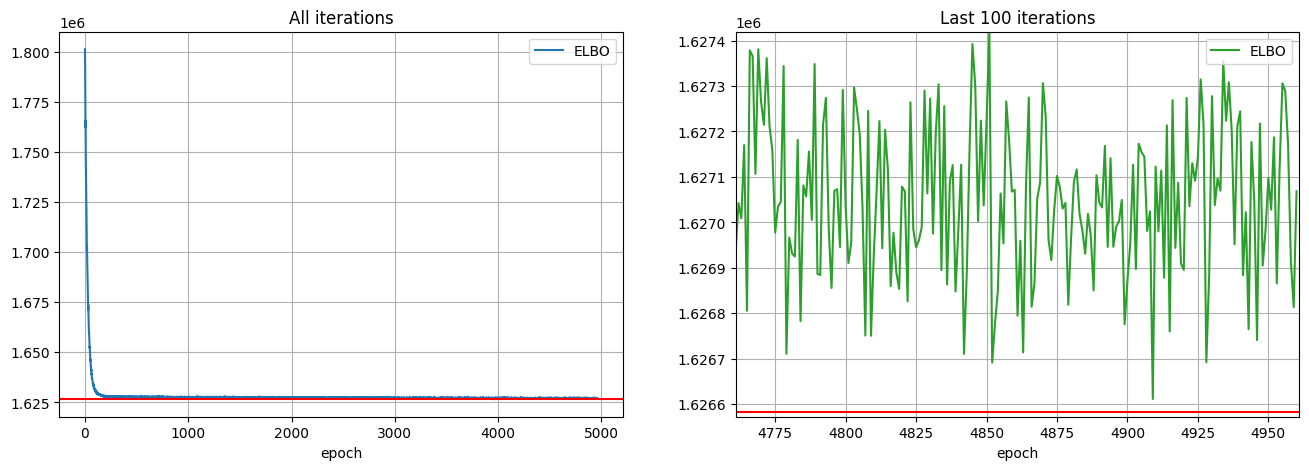

In [24]:
num_steps = 5000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

phase_fit.fit(optimizer=adam, num_steps=num_steps)

## Visualize the results

In [25]:
# Put estimations in new objects
cycle_pyro = phase_fit.cycle_pyro
phase_pyro = phase_fit.phase_pyro

In [26]:
fit_ElogS = phase_fit.posterior["ElogS"].squeeze().numpy()
fit_ElogS2 = phase_fit.posterior["ElogS2"].squeeze().numpy()

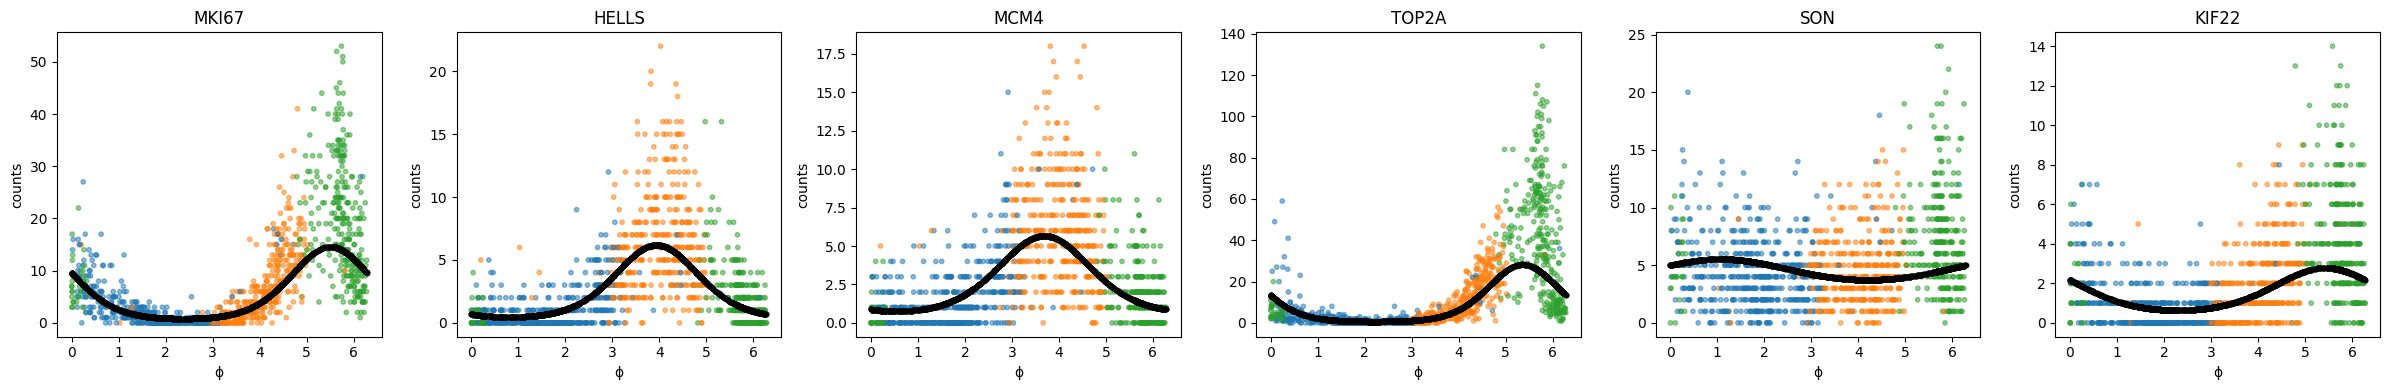

In [27]:
name2color = {'G1':"tab:blue", 'S':"tab:orange", 'G2M':"tab:green"}
gene_list = ["MKI67", "HELLS", "MCM4", "TOP2A", "SON", "KIF22"]
gene_names = np.array(data_to_fit.var.index)
plt.figure(None,(24, 4))
ix = 1
for i in range(0, len(gene_list)):
    g = gene_list[i]
    plt.subplot(1, len(gene_list), ix)
    plt.scatter(phase_pyro.phis, 
                metapar.S[np.where(gene_names==g)[0][0], :].squeeze().cpu().numpy(), 
                s=10, alpha=0.5, c=[name2color[x] for x in data_to_fit.obs["phase"]])
    plt.scatter(phase_pyro.phis, 
                np.exp(fit_ElogS2[np.where(gene_names==g)[0][0], :]), 
                s=10, c="black")
    plt.title(g)
    plt.xlabel("ϕ")
    plt.ylabel("counts")
    ix+=1
plt.tight_layout()
plt.show()

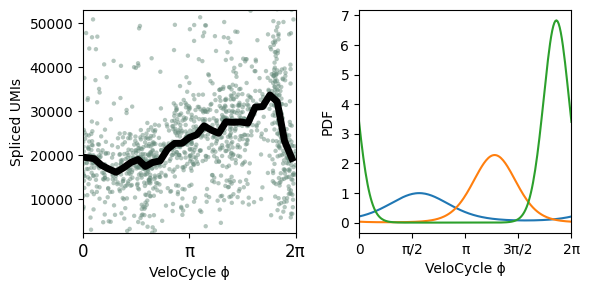

In [30]:
# Visualize results

plt.figure(None, (6, 3))

plt.subplot(1, 2, 1)
nbins=30
means_x = []
means_y = []

for lo, up in zip(np.linspace(0, 2*np.pi, nbins)[:-1], np.linspace(0, 2*np.pi, nbins)[1:]):
    means_x.append(np.mean([lo,up]))
    subset = np.where((phase_pyro.phis.numpy()>=lo) & (phase_pyro.phis.numpy()<up))
    means_y.append(np.median(np.array(data_to_fit.obs.n_scounts)[subset]))

plt.scatter(phase_pyro.phis.numpy(), data_to_fit.obs.n_scounts, edgecolors='none', alpha=0.5, c=CELL_DOT_COLOR, s=10, rasterized=True)
plt.plot(means_x, means_y, color='black', linewidth=5)
plt.ylim(min(data_to_fit.obs.n_scounts), np.percentile(data_to_fit.obs.n_scounts, 98))
plt.xlabel("VeloCycle ϕ")
plt.ylabel("Spliced UMIs")
plt.xlim(0, np.pi*2)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"], size=12)

plt.subplot(1, 2, 2)
m_mean, m_std = pycircstat.mean(phase_pyro.phis[data_to_fit.obs["phase"]=="G2M"].numpy()), pycircstat.std(phase_pyro.phis[data_to_fit.obs["phase"]=="G2M"].numpy())
s_mean, s_std = pycircstat.mean(phase_pyro.phis[data_to_fit.obs["phase"]=="S"].numpy()), pycircstat.std(phase_pyro.phis[data_to_fit.obs["phase"]=="S"].numpy())
g1_mean, g1_std = pycircstat.mean(phase_pyro.phis[data_to_fit.obs["phase"]=="G1"].numpy()), pycircstat.std(phase_pyro.phis[data_to_fit.obs["phase"]=="G1"].numpy())
from scipy.stats import vonmises
import scipy.special as sps

for curr_mu, curr_std, name in zip([g1_mean, s_mean, m_mean], [g1_std, s_std, m_std], ["G1", "S", "G2M"]):
    # Parameters
    mu = curr_mu  # mean (e.g., pi)
    kappa = (1/(curr_std**2))  # concentration (0.5 is analogous to a std dev of 1 in a normal dist)
    
    # Generate an array of angles from 0 to 2pi
    angles = np.linspace(0, 2 * np.pi, 200)
    
    # Generate the von Mises PDF for these angles
    pdf = vonmises.pdf(angles, kappa, loc=mu)
    
    # To better emulate the wrapped normal, you can apply a scaling factor
    scaling_factor = sps.ive(0, kappa) # Bessel function of order 0
    pdf /= scaling_factor
    
    # Create the polar plot
    plt.plot(angles, pdf, c=name2color[name])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.xlim(0, 2*np.pi)
plt.xlabel("VeloCycle ϕ")
plt.ylabel("PDF")
plt.tight_layout()
plt.show()

In [31]:
xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

phis_df = pd.DataFrame([angle, r])
phis_df.columns = data_to_fit.var.index

phase_data_frame = pd.concat([phase_fit.cycle_pyro.means, phase_fit.cycle_pyro.stds, phis_df]).T
phase_data_frame.columns = ["nu0 mean", "nu1sin mean", "nu1cos mean",
                            "nu0 std", "nu1sin std", "nu1cos std", "peak_phase", "amplitude"]
phase_data_frame["is_seurat_marker"] = [True if i in list(utils.S_genes_human)+list(utils.G2M_genes_human) else False for i in phase_data_frame.index]
phase_data_frame.head()

phis_df = pd.DataFrame(phase_fit.phase_pyro.phis.numpy())
phis_df.index = data_to_fit.obs.index
phis_df.columns = ["cell_cycle_phi"]
phase_data_frame_cells = data_to_fit.obs.merge(phis_df, left_index=True, right_index=True)

phase_data_frame.to_csv("IrinaFibro_LargeGeneSet_cycle_gene_harmonics_1harm_metadata.csv")
phase_data_frame_cells.to_csv("IrinaFibro_LargeGeneSet_cycle_cell_phase_1harm_metadata.csv")

In [32]:
# Define the number of bins
num_bins = 10
bin_width = 2 * np.pi / num_bins

# Calculate the bin index for each gene
phase_data_frame['bin_index'] = ((phase_data_frame['peak_phase'] + 2 * np.pi) % (2 * np.pi) / bin_width).astype(int)

# Group genes by bin index and find top 10 genes in each bin
top_genes_per_bin = phase_data_frame.groupby('bin_index', group_keys=False).apply(lambda group: group.nlargest(5, 'amplitude'))

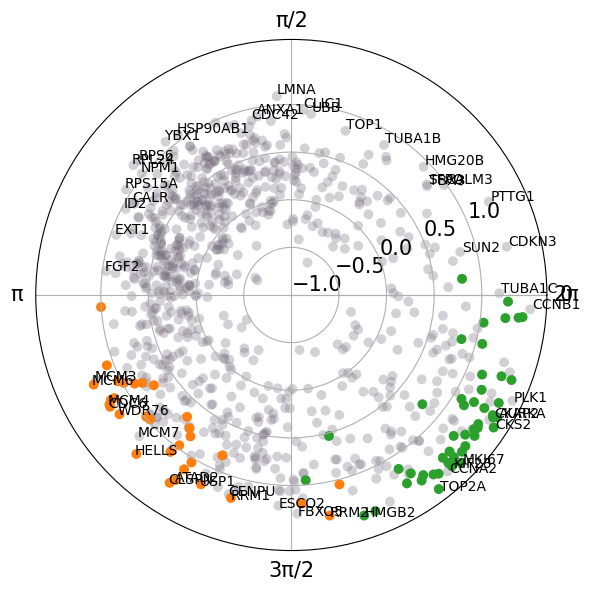

In [33]:
keep_genes = [a.upper() for a in cycle_prior.means.columns]

gene_names = np.array(keep_genes)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.transforms as mtransforms
from cmcrameri import cm
import seaborn as sns

keep_genes = [a.upper() for a in cycle_prior.means.columns]
gene_names = np.array(keep_genes)
S_genes_human = list(utils.S_genes_human)
G2M_genes_human = list(utils.G2M_genes_human)
phases_list = [S_genes_human, G2M_genes_human, [i.upper() for i in gene_names if i.upper() not in S_genes_human+G2M_genes_human]]

g = []
gradient = []
for i in range(len(phases_list)):
    for j in range(len(phases_list[i])):
        g.append(phases_list[i][j])
        gradient.append(i)

color_gradient_map = pd.DataFrame({'Gene': g,  'Color': gradient}).set_index('Gene').to_dict()['Color']
colored_gradient = pd.Series(gene_names).map(color_gradient_map)

xs = phase_fit.fourier_coef[1]
ys = phase_fit.fourier_coef[2]
r = np.log10( np.sqrt(xs**2+ys**2) / phase_fit.fourier_coef_sd[1:, :].sum(0) )
angle = np.arctan2(xs, ys)
angle = (angle)%(2*np.pi)

N=50
width = (2*np.pi) / N

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection='polar')

# First: only plot dots with a color assignment
angle_subset = angle[~np.isnan(colored_gradient.values)]
r_subset = r[~np.isnan(colored_gradient.values)]
color_subset = colored_gradient.values[~np.isnan(colored_gradient.values)]

# Remove genes with very low expression
angle_subset = angle_subset[r_subset>=-12]
color_subset = color_subset[r_subset>=-12]
gene_names_subset = gene_names[r_subset>=-12]
r_subset = r_subset[r_subset>=-12]

x=100
# Take a subset of most highly expressing genes to print the names 
angle_subset_best = angle_subset[r_subset>np.percentile(r_subset, x)]
color_subset_best = color_subset[r_subset>=np.percentile(r_subset, x)]
gene_names_subset_best = gene_names_subset[r_subset>=np.percentile(r_subset, x)]
r_subset_best = r_subset[r_subset>=np.percentile(r_subset, x)]

# Plot all genes in phases list
num2color = {0:"tab:orange", 1:"tab:green", 2:GENE_DOT_COLOR, 3:"tab:blue"}
ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=0.3, edgecolor='none', rasterized=True)

# Select and plot on top the genes marking S and G2M traditionally
angle_subset = angle_subset[color_subset!=2]
r_subset = r_subset[color_subset!=2]
gene_names_subset = gene_names_subset[color_subset!=2]
color_subset = color_subset[color_subset!=2]

ax.scatter(angle_subset, r_subset, c=[num2color[i] for i in color_subset], s=50, alpha=1, edgecolor='none',rasterized=True)

# Annotate genes
for (i, txt), c in zip(enumerate(gene_names), colored_gradient.values):
    if txt in top_genes_per_bin.index:
        ix = np.where(np.array(gene_names)==txt)[0][0]
        ax.annotate(txt[0]+txt[1:].upper(), (angle[ix], r[ix]+0.02))

plt.xlim(0, 2*np.pi)
plt.ylim(-1, )
plt.yticks([-1, -0.5, 0, 0.5, 1], size=15)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"], size=15)
plt.tight_layout()
plt.show()

# Run the velocity-learning module

In [34]:
pyro.clear_param_store()

In [35]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [36]:
n_velo_harmonics = 0
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["fibroblasts"], harmonics=n_velo_harmonics, 
                                                means=0.0, stds=3.0)

In [37]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [38]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics, 
                                                             gene_selection_model="all",
                                                             normalize=False,
                                                             noisemodel="NegativeBinomial",
                                                             μγ=torch.tensor(0.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σγ=torch.tensor(0.5).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             μβ=torch.tensor(2.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σβ=torch.tensor(3.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             device=device, 
                                                             model_type="lrmn",
                                                             rho_mean=torch.tensor(4.0).to(device),
                                                             rho_rank=torch.tensor(5).to(device),
                                                             condition_on=condition_on_dict)

In [39]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict, early_exit=False,
                                                        num_samples=500, n_per_bin=50)

In [40]:
velocity_fit.check_model()

  Trace Shapes:                                    
   Param Sites:                                    
  Sample Sites:                                    
     cells dist                |                   
          value           1222 |                   
     genes dist                |                   
          value            876 |                   
 harmonics dist                |                   
          value              1 |                   
conditions dist                |                   
          value              1 |                   
   batches dist                |                   
          value              1 |                   
     logγg dist       876    1 |                   
          value       876    1 |                   
     logβg dist       876    1 |                   
          value       876    1 |                   
  rho_real dist       876    1 |                   
          value       876    1 |                   
        γg d

In [41]:
velocity_fit.check_guide()

  Trace Shapes:                 
   Param Sites:                 
         ν_locs     876    1   3
       ν_scales     876    1   3
        Δν_locs 1 1   1  876   1
       ϕxy_locs         1222   2
     logβg_locs          876   1
   logβg_scales          876   1
            loc              877
     cov_factor          877   5
       cov_diag              877
   rho_real_loc              876
 shape_inv_locs          876   1
  Sample Sites:                 
     cells dist                |
          value         1222   |
     genes dist                |
          value          876   |
 harmonics dist                |
          value            1   |
conditions dist                |
          value            1   |
   batches dist                |
          value            1   |
     logγg dist     876    1   |
          value     876    1   |
  rho_real dist     876    1   |
          value     876    1   |
     logβg dist     876    1   |
          value     876    1   |
        νω

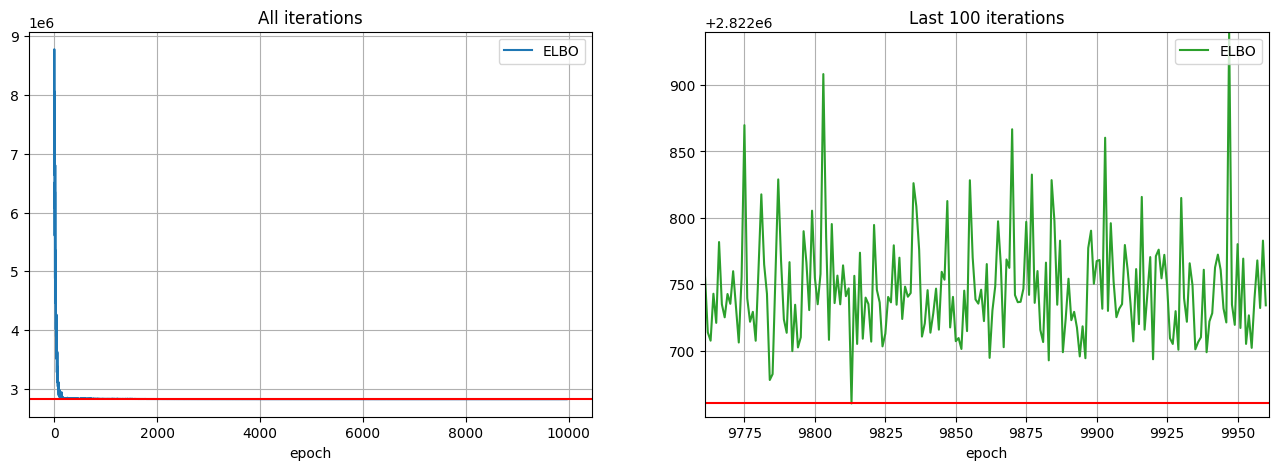

In [42]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [43]:
velocity_fit.speed_pyro

In [44]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

In [45]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit.posterior

In [46]:
# See the value of the mean gamma
torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

array(1.0536888, dtype=float32)

15.466219 0.39727226


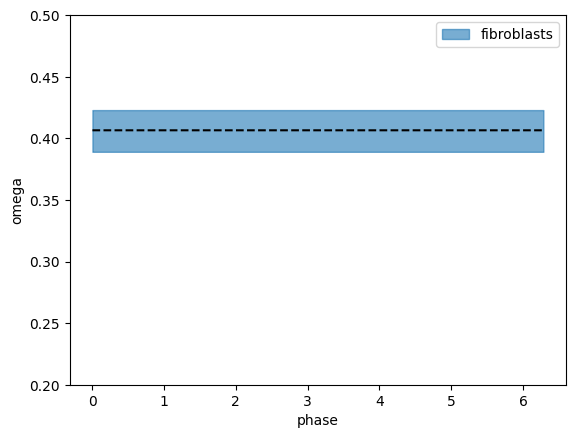

In [47]:
# Visualize the constant velocity estimate
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"fibroblasts":0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])
plt.xlabel("phase")
plt.ylabel("omega")
plt.ylim(0.2, 0.5)
plt.legend()
plt.show()

In [48]:
velocity_fit0 = velocity_fit

In [49]:
del velocity_fit0.metaparams
del velocity_fit0.metaparams_avg

In [52]:
pickle.dump(velocity_fit0, open("IrinaFibro_Large_wh0_velocity_fit1.pkl", "wb"))

In [53]:
pyro.clear_param_store()

In [54]:
condition_design_matrix = copy.deepcopy(batch_design_matrix)

In [55]:
n_velo_harmonics = 1
speed_prior = angularspeed.AngularSpeed.trivial_prior(condition_names=["untreated"], harmonics=n_velo_harmonics, 
                                                means=0.0, stds=3.0)

speed_prior.stds.loc["nu1_cos"] = 0.05
speed_prior.stds.loc["nu1_sin"] = 0.05

In [57]:
condition_on_dict = {"ϕxy":phase_pyro.phi_xy_tensor.T.to(device),
                     "ν": cycle_pyro.means_tensor.T.unsqueeze(-2).to(device),
                     "Δν": torch.tensor(phase_fit.delta_nus).to(device),
                     "shape_inv": torch.tensor(phase_fit.disp_pyro).unsqueeze(-1).to(device)}

In [58]:
metaparameters_velocity = preprocessing.preprocess_for_velocity_estimation(data_to_fit, 
                                                             cycle_pyro, 
                                                             phase_pyro, 
                                                             speed_prior,
                                                             condition_design_matrix.float(), 
                                                             batch_design_matrix.float(), 
                                                             n_harmonics=n_harm,
                                                             count_factor=metapar.count_factor,
                                                             ω_n_harmonics=n_velo_harmonics, 
                                                             gene_selection_model="all",
                                                             normalize=False,
                                                             noisemodel="NegativeBinomial",
                                                             μγ=torch.tensor(0.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σγ=torch.tensor(0.5).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             μβ=torch.tensor(2.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             σβ=torch.tensor(3.0).detach().clone().float().repeat([metapar.Ng, 1]),
                                                             device=device, 
                                                             model_type="lrmn",
                                                             rho_mean=torch.tensor(4.0).to(device),
                                                             rho_rank=torch.tensor(5).to(device),
                                                             condition_on=condition_on_dict)

In [59]:
velocity_fit = velocity_inference_model.VelocityFitModel(metaparams=metaparameters_velocity, 
                                                         condition_on=condition_on_dict, early_exit=False,
                                                        num_samples=500, n_per_bin=50)

In [60]:
velocity_fit.check_model()

  Trace Shapes:                                    
   Param Sites:                                    
  Sample Sites:                                    
     cells dist                |                   
          value           1222 |                   
     genes dist                |                   
          value            876 |                   
 harmonics dist                |                   
          value              3 |                   
conditions dist                |                   
          value              1 |                   
   batches dist                |                   
          value              1 |                   
     logγg dist       876    1 |                   
          value       876    1 |                   
     logβg dist       876    1 |                   
          value       876    1 |                   
  rho_real dist       876    1 |                   
          value       876    1 |                   
        γg d

In [61]:
velocity_fit.check_guide()

  Trace Shapes:                 
   Param Sites:                 
         ν_locs     876    1   3
       ν_scales     876    1   3
        Δν_locs 1 1   1  876   1
       ϕxy_locs         1222   2
     logβg_locs          876   1
   logβg_scales          876   1
            loc              879
     cov_factor          879   5
       cov_diag              879
   rho_real_loc              876
 shape_inv_locs          876   1
  Sample Sites:                 
     cells dist                |
          value         1222   |
     genes dist                |
          value          876   |
 harmonics dist                |
          value            3   |
conditions dist                |
          value            1   |
   batches dist                |
          value            1   |
     logγg dist     876    1   |
          value     876    1   |
  rho_real dist     876    1   |
          value     876    1   |
     logβg dist     876    1   |
          value     876    1   |
        νω

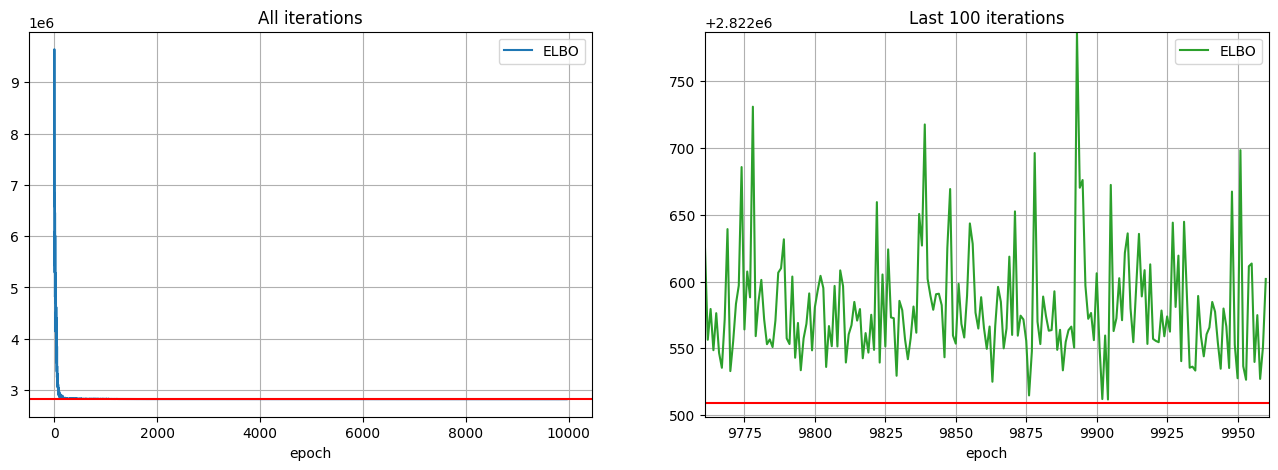

In [62]:
num_steps = 10000
initial_lr = 0.03
final_lr = 0.005
gamma = final_lr / initial_lr
lrd = gamma ** (1 / num_steps)
adam = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd, 'betas': (0.80, 0.99)})

velocity_fit.fit(optimizer=adam, num_steps=num_steps)

In [63]:
# Put estimations in new objects
cycle_pyro = velocity_fit.cycle_pyro
phase_pyro = velocity_fit.phase_pyro
speed_pyro = velocity_fit.speed_pyro

fit_ElogS = velocity_fit.posterior["ElogS"].squeeze()
fit_ElogU = velocity_fit.posterior["ElogU"].squeeze()

fit_ElogS2 = velocity_fit.posterior["ElogS2"].squeeze()
fit_ElogU2 = velocity_fit.posterior["ElogU2"].squeeze()

log_gammas = velocity_fit.log_gammas
log_betas = velocity_fit.log_betas

In [64]:
# Store entire posterior sampling into an object
full_pps_velo = velocity_fit.posterior

In [65]:
# See the value of the mean gamma
torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

array(1.0546113, dtype=float32)

16.038832 2.6602297


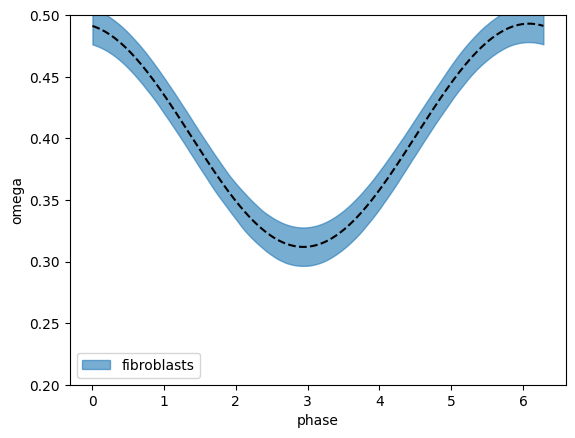

In [66]:
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = phase_pyro.phis
omegas = []
phis = []
n2n = {"fibroblasts":0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="black", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 5, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 95, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=0.6, color=colors[i], label = labels[i])
plt.xlabel("phase")
plt.ylabel("omega")
plt.ylim(0.2, 0.5)
plt.legend()
plt.show()

In [67]:
velocity_fit1 = velocity_fit

In [68]:
del velocity_fit1.metaparams
del velocity_fit1.metaparams_avg

In [69]:
pickle.dump(velocity_fit1, open("IrinaFibro_Large_wh1_velocity_fit1.pkl", "wb"))

In [70]:
del phase_fit.metaparams
del phase_fit.metaparams_avg
pickle.dump(phase_fit, open("IrinaFibro_Large_phase_fit.pkl", "wb"))

# Load the results from the analyses above and make some visualizations

In [71]:
import pickle
velocity_fit0 = pickle.load(open("IrinaFibro_Large_wh0_velocity_fit1.pkl", "rb"))
velocity_fit1 = pickle.load(open("IrinaFibro_Large_wh1_velocity_fit1.pkl", "rb"))

In [72]:
data_to_fit

AnnData object with n_obs × n_vars = 1222 × 876
    obs: 'batch', 'S_score', 'G2M_score', 'phase', 'n_scounts', 'n_ucounts'
    layers: 'spliced', 'unspliced', 'S_sz', 'U_sz', 'S_sz_log', 'logS', 'logU'

In [74]:
# Import class files from the original study acquiring these data (Capolupo et al 2022)
import numpy as np
from typing import Any, List, Tuple, Optional, Iterable
from skimage.measure import regionprops
from skimage.io import imread
from skimage.morphology import convex_hull
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.svm import SVR
from sklearn.preprocessing import quantile_transform
#from sknetwork.clustering import Louvain
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding, Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans, DBSCAN
import seaborn as sns
from copy import deepcopy
# %config InlineBackend.figure_format = 'retina'
#plt.rcParams["figure.dpi"] = 140
#plt.rcParams['pdf.fonttype'] = 42


def despline(ax1: Any) -> None:
    # Hide the right and top spines
    ax1.spines["right"].set_visible(False)
    ax1.spines["top"].set_visible(False)
    ax1.spines["bottom"].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax1.yaxis.set_ticks_position("left")
    ax1.xaxis.set_ticks_position("bottom")
    ax1.set_xticks(ticks=[])

def flatten(l: Iterable) -> Iterable:
    for el in l:
        if isinstance(el, Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el
    
class Cell:
    def __init__(self, cid: int, coords: np.ndarray):
        self.cid = cid
        self.coords = coords
        self.t0 = np.min(coords[:, 0])
        self.coord0 = coords[np.argmin(coords[:, 0]), 1:]
        self.tf = np.max(coords[:, 0])
        self.coordf = coords[np.argmax(coords[:, 0]), 1:]
        self.parent = None
        self.children: List[Any] = []
        self.dendrogram_x: Optional[float] = None
        self.dendrogram_y: Optional[float] = None
        self.color_var = (0.7,0.7,0.7)
        self.colored_value = None

    @property
    def is_root(self) -> Any:
        return self.parent is None

    @property
    def is_leaf(self) -> Any:
        return len(self.children) == 0

    def set_parent(self, cell: Any) -> None:
        self.parent = cell
        cell.children.append(self)

    def add_child(self, cell: Any) -> None:
        if cell not in self.children:
            self.children.append(cell)
        cell.parent = self

    def family_struct(self) -> Tuple:
        if len(self.children):
            # IMPORTANT this has been changed to allow the code to wrok after pruning the tree
            # return self, (self.children[0].family_struct(), self.children[1].family_struct())
            return self, tuple(self.children[i].family_struct() for i in range(len(self.children)))
        else:
            return (self,)
        
    
    @property
    def n_generations_below(self) -> int:
        if len(self.children):
            return 1 + max((child.n_generations_below for child in self.children))
        else:
            return 0
    
    @property
    def family_members(self) -> List:
        # only downstream!!!!
        return list(flatten(self.family_struct()))
    
    @property
    def clade_tuple(self) -> List:
        return tuple(sorted([i.cid for i in flatten(self.family_struct())]))
    
    @property
    def first_ancestor(self):
        if self.parent is not None:
            return self.parent.first_ancestor
        else:
            return self
    
    @property
    def sister(self):
        if self.parent is not None:
            for i in self.parent.children:
                if i is not self:
                    return i
        return None
    
    @property
    def aunt(self):
        if self.parent is not None:
            return self.parent.sister
        return None
    
    @property
    def cousins(self):
        if self.parent is not None:
            if self.parent.sister:
                return self.parent.sister.children
        return []

    def __str__(self) -> str:
        _str = f"Cell {self.cid}"
        return _str

    def __repr__(self) -> str:
        _str = f"'<Cell_{self.cid}>'"
        return _str


def aggregate(x: np.ndarray, ix: np.ndarray) -> np.ndarray:
    uq, bounds = np.unique(ix, return_index=True)
    z = np.zeros((len(bounds), x.shape[1] + 1))
    z[:, 0] = uq
    for i in range(len(bounds) - 1):
        z[i, 1:] = np.mean(x[bounds[i] : bounds[i + 1], :], 0)
    z[-1, 1:] = np.mean(x[bounds[-1] :, :], 0)
    return z


def assign_parenthood(cells: List[Cell]) -> None:
    tf = np.array([c.tf for c in cells])
    t0 = np.array([c.t0 for c in cells])
    tD = 1 + tf - t0[:, None]

    for child_id in range(tD.shape[0]):
        p_candidates = np.where(tD[child_id, :] == 0)[0]
        if len(p_candidates) == 0:
            continue
        elif len(p_candidates) == 1:
            parent_id = p_candidates[0]
        else:
            c0s = cells[child_id].coord0
            cfs = np.array([cells[p_id].coordf for p_id in p_candidates])
            dist = np.sum((c0s - cfs) ** 2, -1)
            parent_id = p_candidates[np.argmin(dist)]
        cells[child_id].set_parent(cells[parent_id])


def make_annotations(cells: List[Cell]) -> Tuple[np.ndarray, np.ndarray]:
    lines = []
    points = []
    for c in cells:
        if len(c.children) > 0:
            c1, c2 = c.children
            line = np.array(
                [[c1.t0, c1.coord0[0], c1.coord0[1]], [c2.t0, c2.coord0[0], c2.coord0[1]]]
            )
            point = np.array([c.tf, c.coordf[0], c.coordf[1]])
            lines.append(line)
            points.append(point)
    lines = np.stack(lines)
    points = np.stack(points)
    return lines, points


def trow_error(message, errortype="Error"):
    msg = QMessageBox()
    msg.setText(errortype)
    msg.setIcon(QMessageBox.Critical)
    msg.setInformativeText(message)
    msg.setWindowTitle("Error message")
    msg.exec_()

def validate_parenthood(cells):
    l = []
    for c in cells:
        if len(c.children) == 1:
            l.append(c)
    ids = [str(c.cid) for c in l]
    l = []
    for c in cells:
        if len(c.children) == 1:
            l.append(c)
    ids2 = [str(c.cid) for c in l]
    if len(ids) and len(ids2):
        trow_error(f"Cells {', '.join(ids)} have only one child, {', '.join(ids2)} more than two!", "Annotation Error")
    elif len(ids2):
        trow_error(f"Cells {', '.join(ids2)} have more than two children!", "Annotation Error")
    elif len(ids):
        trow_error(f"Cells {', '.join(ids)} have only one child!", "Annotation Error")
    
    
def analyze(data) -> None:
    cells = []
    objects = regionprops(data[:, :, :])
    for ob in objects:
        coords = aggregate(ob.coords[:, 1:], ob.coords[:, 0])
        cells.append(Cell(int(ob.label), coords))
    assign_parenthood(cells)
    
    if validate_parenthood(cells):
        return
    lines, points = make_annotations(cells)
    for i, ly in enumerate(viewer.layers):
        if ly.name == "Sisters":
            viewer.layers.pop(i)
            break
    for i, ly in enumerate(viewer.layers):
        if ly.name == "Divisions":
            viewer.layers.pop(i)
            break
    viewer.add_shapes(lines, name="Sisters", shape_type="line", edge_width=3, edge_color="w")
    viewer.add_points(
        points, name="Divisions", symbol="o", size=5, edge_width=1, face_color="red"
    )
    
    
def select_leaves(cells: List[Cell]) -> List[Cell]:
    leaves = []
    for c in cells:
        if c.is_leaf:
            leaves.append(c)
    return leaves


def parent_order(c: Cell) -> List:
    out = []
    while c.parent:
        out.append(c.cid)
        c = c.parent
    out.append(c.cid)
    return tuple(out[::-1])

# New Functions

def is_inside_box(cell, bbox):
    min_row, min_col, max_row, max_col = bbox
    r, c = cell.coordf
    if r > min_row and r < max_row:
        if c > min_col and c < max_col:
            return True
    return False

def select_inside_mass(cells, mass):
    if len(mass.shape) == 4:
        bbox = regionprops(convex_hull.convex_hull_image(mass[0,...].sum(0)).astype(int))[0].bbox
    elif len(mass.shape) == 3:
        bbox = regionprops(convex_hull.convex_hull_image(mass.sum(0)).astype(int))[0].bbox
    else:
        raise ValueError("Mass Image is of the wrong shape")
        
    return [cell for cell in cells if is_inside_box(cell, bbox)]


def assign_color(cells, c_vector, cmap=plt.cm.Reds, perc=None,vmin=None, vmax=None):
    assert len(cells) == len(c_vector)
    assert not all((perc is not None, (vmin is not None or vmax is not None)))
    if perc is not None:
        vmin, vmax = np.percentile(c_vector, perc)
    else:
        if vmin is None:
            vmin = c_vector.min()
        if vmax is None:
            vmax = c_vector.max()
    colorandum = np.clip(c_vector, vmin, vmax)
    colorandum = colorandum - np.min(colorandum)
    colorandum = colorandum / np.max(colorandum)
    for i, c in enumerate(cells):
        c.color_var = cmap(colorandum[i])
        c.colored_value = c_vector[i]
        
def all_parents(c):
    parents = []
    current = c
    while current.parent:
        parents.append(current.parent)
        current = current.parent
    return parents

def mitotic_disance(c1, c2):
    if c1 is c2:
        return 0
    parents_c1 = all_parents(c1)
    i = 1
    current = c2
    while current.parent:
        if current.parent in parents_c1:
            for j, c in enumerate(parents_c1):
                if c is current.parent:
                    return max(i, j+1)
        i+=1
        current = current.parent
    return np.inf

In [75]:
cells_tracked = pickle.load(open("Data/cells_obj_list_movie1_20220707.pkl", "rb"))

In [76]:
cells_dict = {c.cid:c for c in cells_tracked}

In [77]:
from collections import Counter
Counter([cells_dict[i].tf for i in cells_dict.keys()]).most_common(10)

[(124.0, 1653),
 (122.0, 35),
 (119.0, 28),
 (114.0, 28),
 (121.0, 25),
 (115.0, 25),
 (113.0, 22),
 (112.0, 22),
 (116.0, 21),
 (105.0, 21)]

In [78]:
full_cycle_lengths = []
endpoints = [124]#, 132, 127, 129, 122]
for cid in cells_dict.keys():
    curr_cell = cells_dict[cid]
    t0 = curr_cell.t0
    tf = curr_cell.tf
    
    if (tf not in endpoints) and (t0 != 0):
        if tf-t0 > (8*3) and tf-t0 < (32*3): #3x20mins = 1 h
            full_cycle_lengths.append(tf-t0)
        if (tf-t0)<10:
            continue #print(cid, t0, tf)
full_cycle_lengths = np.array(full_cycle_lengths)

In [79]:
len(full_cycle_lengths)

282

In [80]:
np.mean(full_cycle_lengths), np.median(full_cycle_lengths)

(47.42198581560284, 46.0)

In [81]:
# Cell cycle length (mean and median)
(np.mean(full_cycle_lengths)*20)/60, (np.median(full_cycle_lengths)*20)/60

(15.807328605200947, 15.333333333333334)

In [82]:
np.std(full_cycle_lengths*20/60)

3.6568094284765698

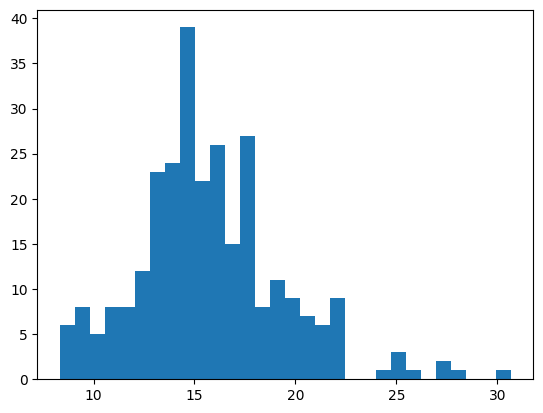

In [83]:
plt.hist((full_cycle_lengths*20)/60, bins=30)
plt.show()

In [84]:
len(full_cycle_lengths)

282

15.466219 0.39727226
16.038832 2.6602297


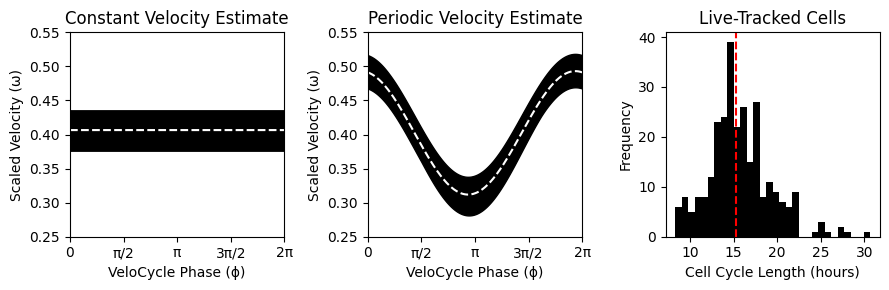

In [86]:
plt.figure(None, (9, 3))

plt.subplot(1, 3, 1)
full_pps_velo = velocity_fit0.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = velocity_fit0.phase_pyro.phis
omegas = []
phis = []
n2n = {"fibroblasts": 0}
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique())

colors = ["black", "tab:orange", "tab:green", "tab:red"]
for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="white", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 0, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 100, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=1, color=colors[i], label = labels[i])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.ylim(0.25, 0.55)
plt.xlim(0, 2*np.pi)
plt.xlabel("VeloCycle Phase (ϕ)")
plt.ylabel("Scaled Velocity (ω)") 
plt.title("Constant Velocity Estimate")

plt.subplot(1,3,3)
plt.hist((full_cycle_lengths*20)/60, bins=30, color='black')
plt.axvline(np.median((full_cycle_lengths*20)/60), c='red', linestyle='dashed')
plt.xlabel("Cell Cycle Length (hours)")
plt.ylabel("Frequency") 
plt.title("Live-Tracked Cells")

plt.subplot(1, 3, 2)
full_pps_velo = velocity_fit1.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = velocity_fit1.phase_pyro.phis
omegas = []
phis = []
ids = np.array([n2n[i] for i in np.array(data_to_fit.obs["batch"])])
for i in range(len(data_to_fit.obs["batch"].unique())):
    omega1 = omega[:,np.where(ids == i)]
    phi1 = phi[np.where(ids == i)]
    omegas.append(omega1)
    phis.append(phi1)

labels = np.array(data_to_fit.obs["batch"].unique()) #list(adatas.keys())

for i in range(len(omegas)):
    plt.plot(phis[i][np.argsort(phis[i])], omegas[i].mean(0)[0][np.argsort(phis[i])], c="white", linestyle='dashed')
    
    tmp5 = np.percentile(omega[:, ids==i], 0, axis=0)
    tmp95 = np.percentile(omega[:, ids==i], 100, axis=0)
    print(((2*np.pi)/omega[:, ids==i]).mean(), ((2*np.pi)/omega[:, ids==i]).std())
    phi_i = phi[ids==i] 
    plt.fill_between(x=phi_i[np.argsort(phi_i)],
                     y1=tmp5[np.argsort(phi_i)], 
                     y2=tmp95[np.argsort(phi_i)], 
                     alpha=1, color=colors[i], label = labels[i])
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
plt.ylim(0.25, 0.55)
plt.xlim(0, 2*np.pi)
plt.xlabel("VeloCycle Phase (ϕ)")
plt.ylabel("Scaled Velocity (ω)") 
plt.title("Periodic Velocity Estimate")

plt.tight_layout()
plt.show()

In [87]:
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit1.log_gammas))
full_pps_velo = velocity_fit1.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=1).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 100)-np.percentile(period, 0)), np.mean(period)

(1.108454704284668, 16.032288)

In [88]:
from scipy.integrate import trapz
period = []

mean_gamma  = np.exp(np.mean(velocity_fit0.log_gammas))
full_pps_velo = velocity_fit0.posterior
nu_omega = full_pps_velo["νω"].squeeze()/mean_gamma

grid_phi = torch.tensor(np.linspace(0, 2*np.pi, 20)).float()
omegas_on_grid = nu_omega.unsqueeze(-1) @ utils.torch_basis(grid_phi, kind="fourier", num_harmonics=0).T
period = trapz(1/omegas_on_grid, grid_phi)

0.5*(np.percentile(period, 100)-np.percentile(period, 0)), np.mean(period)

(1.1364827156066895, 15.466217)

In [89]:
full_pps_velo = velocity_fit0.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

In [90]:
omega.mean(0), omega.min(0), omega.max(0)

(array([0.40651906, 0.40651906, 0.40651906, ..., 0.40651906, 0.40651906,
        0.40651906], dtype=float32),
 array([0.37626258, 0.37626258, 0.37626258, ..., 0.37626258, 0.37626258,
        0.37626258], dtype=float32),
 array([0.43554673, 0.43554673, 0.43554673, ..., 0.43554673, 0.43554673,
        0.43554673], dtype=float32))

In [91]:
data_to_fit.obs["phase"].value_counts()

phase
G1     514
S      383
G2M    325
Name: count, dtype: int64

In [92]:
full_pps_velo = velocity_fit1.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()

In [93]:
omega[:, data_to_fit.obs["phase"]=="G1"].mean(), omega[:, data_to_fit.obs["phase"]=="G1"].max()-omega[:, data_to_fit.obs["phase"]=="G1"].min()

(0.37786072, 0.23689827)

In [94]:
omega[:, data_to_fit.obs["phase"]=="S"].mean(), omega[:, data_to_fit.obs["phase"]=="S"].max()-omega[:, data_to_fit.obs["phase"]=="S"].min()

(0.3665767, 0.23412111)

In [95]:
omega[:, data_to_fit.obs["phase"]=="G2M"].mean(), omega[:, data_to_fit.obs["phase"]=="G2M"].max()-omega[:, data_to_fit.obs["phase"]=="G2M"].min()

(0.48436832, 0.11656192)

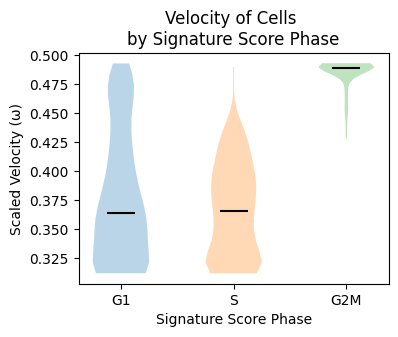

In [96]:
import matplotlib.pyplot as plt

plt.figure(None, (4, 3))
# Sample data sets - I'm using dummy data here; you should use your actual data
data1 = omega[:, data_to_fit.obs["phase"]=="G1"].mean(0)
data2 = omega[:, data_to_fit.obs["phase"]=="S"].mean(0)
data3 = omega[:, data_to_fit.obs["phase"]=="G2M"].mean(0)

# Combine the three data sets into a list
all_data = [data1, data2, data3]

# Create the violin plot
parts = plt.violinplot(all_data, showmedians=True, points=20, showextrema=False)

# Specify the colors you want to use
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Loop to set the colors
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)

# Set the color for the mean line
for partname in ('cmedians',):
    part = parts[partname]
    part.set_edgecolor('black')
    part.set_linewidth(1.5)
    
# Customize ticks and labels
plt.xticks([1, 2, 3], ['G1', 'S', 'G2M'])

# Add title and axis labels
plt.title("Velocity of Cells \nby Signature Score Phase")
plt.xlabel("Signature Score Phase")
plt.ylabel("Scaled Velocity (ω)")
plt.show()

In [97]:
data1.mean(), data2.mean(), data3.mean()

(0.37786075, 0.36657667, 0.48436832)

In [98]:
# Investigate changes to the shift along the cell cycle with non-zero harmonic. Should the shift change?

In [99]:
cycle_data_frame = pd.read_csv("IrinaFibro_LargeGeneSet_cycle_gene_harmonics_1harm_metadata.csv", index_col=0)
phase_data_frame = pd.read_csv("IrinaFibro_LargeGeneSet_cycle_cell_phase_1harm_metadata.csv", index_col=0)

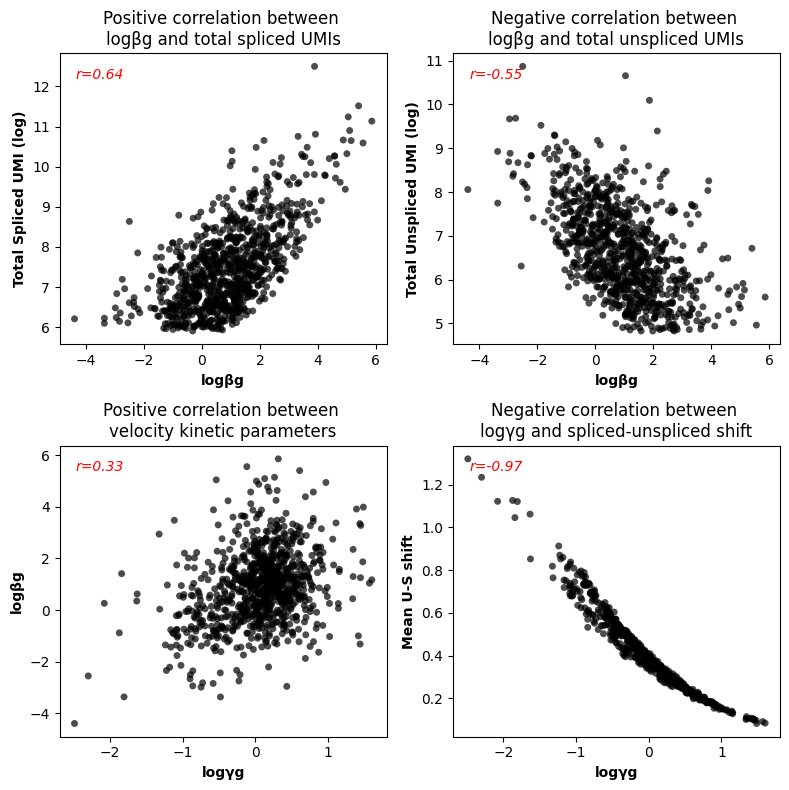

In [100]:
S = data_to_fit.layers["S_sz"]#.toarray()
U = data_to_fit.layers["U_sz"]#.toarray()

ζ = velocity_fit0.posterior["ζ"].mean(0).squeeze().numpy()
phis = velocity_fit0.phase_pyro.phis

from scipy.linalg import lstsq

import statsmodels.api as sm
Ng = data_to_fit.n_vars
nu = np.zeros((Ng, 3))

Sraw = data_to_fit.layers["spliced"].toarray()
Uraw = data_to_fit.layers["unspliced"].toarray()
for g in range(Ng):
    y_col = Sraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nu[g, :] = model.params

nuU = np.zeros((Ng, 3))
for g in range(Ng):
    y_col = Uraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nuU[g, :] = model.params

ElogS = (ζ @ nu.T)
ElogU = (ζ @ nuU.T)

fit_ElogS2 = velocity_fit0.posterior["ElogS2"]
fit_ElogU2 = velocity_fit0.posterior["ElogU2"]


fit_ElogS = velocity_fit0.posterior["ElogS"]
fit_ElogU = velocity_fit0.posterior["ElogU"]

import pycircstat
shift_pred = pycircstat.cdiff(phis[np.argmax(ElogS, axis=0)], phis[np.argmax(ElogU, axis=0)])
shift_obs = pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)])
shift_obs_raw_data = pycircstat.cdiff(phis[np.argmax(fit_ElogS.numpy().T, axis=0)], phis[np.argmax(fit_ElogU.numpy().T, axis=0)])

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Create a function to compute the Pearson correlation and add it as text to the plot
def add_pearson_corr_text(x, y, ax):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={corr:.2f}", color='red', ha='left', va='top', transform=ax.transAxes, style='italic')

# Initialize the figure
plt.figure(None, (8, 8))

# Plot 1
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg", fontweight='bold')
plt.ylabel("Total Spliced UMI (log)", fontweight='bold')
plt.title("Positive correlation between \nlogβg and total spliced UMIs")  # Modify as needed
add_pearson_corr_text(velocity_fit0.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), ax1)

# Plot 2
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(velocity_fit0.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg", fontweight='bold')
plt.ylabel("Total Unspliced UMI (log)", fontweight='bold')
plt.title("Negative correlation between \nlogβg and total unspliced UMIs")  # Modify as needed
add_pearson_corr_text(velocity_fit0.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), ax2)

# Plot 3
ax3 = plt.subplot(2, 2, 3)
ax3.scatter(velocity_fit0.log_gammas, velocity_fit0.log_betas, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg", fontweight='bold')
plt.ylabel("logβg", fontweight='bold')
plt.title("Positive correlation between \nvelocity kinetic parameters")  # Modify as needed
add_pearson_corr_text(velocity_fit0.log_gammas, velocity_fit0.log_betas, ax3)

# Plot 4
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(velocity_fit0.log_gammas, shift_obs, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg", fontweight='bold')
plt.ylabel("Mean U-S shift", fontweight='bold')
plt.title("Negative correlation between \nlogγg and spliced-unspliced shift")  # Modify as needed
add_pearson_corr_text(velocity_fit0.log_gammas, shift_obs, ax4)

plt.tight_layout()
plt.show()

In [101]:
S = data_to_fit.layers["S_sz"]#.toarray()
U = data_to_fit.layers["U_sz"]#.toarray()

ζ = velocity_fit1.posterior["ζ"].mean(0).squeeze().numpy()
phis = velocity_fit1.phase_pyro.phis

from scipy.linalg import lstsq

import statsmodels.api as sm
Ng = data_to_fit.n_vars
nu = np.zeros((Ng, 3))

Sraw = data_to_fit.layers["spliced"].toarray()
Uraw = data_to_fit.layers["unspliced"].toarray()
for g in range(Ng):
    y_col = Sraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nu[g, :] = model.params

nuU = np.zeros((Ng, 3))
for g in range(Ng):
    y_col = Uraw[:, g]
    model = sm.GLM(y_col, ζ, family=sm.families.NegativeBinomial(alpha=100)).fit()
    nuU[g, :] = model.params

#nu, *_ = lstsq(ζ, np.log(S+1))
#nuU, *_ = lstsq(ζ, np.log(U+1))
ElogS = (ζ @ nu.T)
ElogU = (ζ @ nuU.T)

fit_ElogS2 = velocity_fit1.posterior["ElogS2"]
fit_ElogU2 = velocity_fit1.posterior["ElogU2"]


fit_ElogS = velocity_fit1.posterior["ElogS"]
fit_ElogU = velocity_fit1.posterior["ElogU"]

import pycircstat
shift_pred = pycircstat.cdiff(phis[np.argmax(ElogS, axis=0)], phis[np.argmax(ElogU, axis=0)])
shift_obs = pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)])
shift_obs_raw_data = pycircstat.cdiff(phis[np.argmax(fit_ElogS.numpy().T, axis=0)], phis[np.argmax(fit_ElogU.numpy().T, axis=0)])

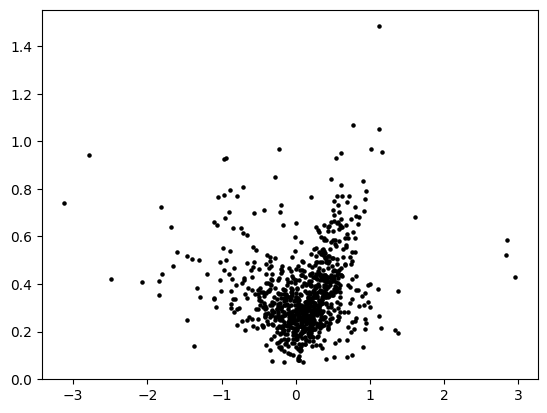

In [102]:
plt.scatter(shift_pred, shift_obs, c='black', s=5)
plt.show()

In [103]:
np.corrcoef(shift_pred, shift_obs)

array([[1.        , 0.05513159],
       [0.05513159, 1.        ]])

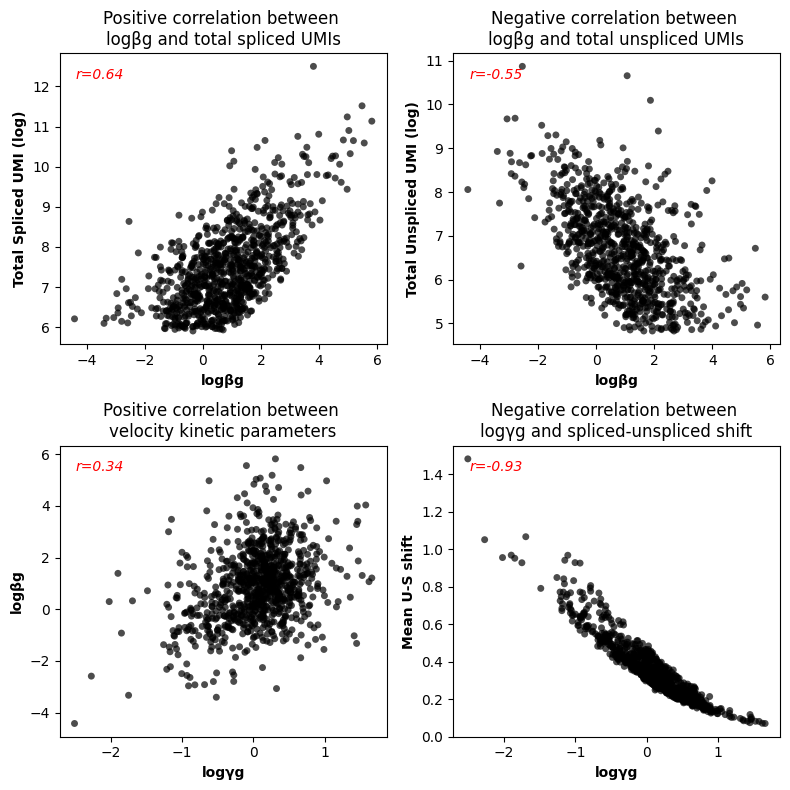

In [104]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Create a function to compute the Pearson correlation and add it as text to the plot
def add_pearson_corr_text(x, y, ax):
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"r={corr:.2f}", color='red', ha='left', va='top', transform=ax.transAxes, style='italic')

# Initialize the figure
plt.figure(None, (8, 8))

# Plot 1
ax1 = plt.subplot(2, 2, 1)
ax1.scatter(velocity_fit1.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg", fontweight='bold')
plt.ylabel("Total Spliced UMI (log)", fontweight='bold')
plt.title("Positive correlation between \nlogβg and total spliced UMIs")  # Modify as needed
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["spliced"].toarray().sum(0)), ax1)

# Plot 2
ax2 = plt.subplot(2, 2, 2)
ax2.scatter(velocity_fit1.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), c='black', edgecolor='none', s=25, alpha=0.7, rasterized=True)
plt.xlabel("logβg", fontweight='bold')
plt.ylabel("Total Unspliced UMI (log)", fontweight='bold')
plt.title("Negative correlation between \nlogβg and total unspliced UMIs")  # Modify as needed
add_pearson_corr_text(velocity_fit1.log_betas, np.log(data_to_fit.layers["unspliced"].toarray().sum(0)), ax2)

# Plot 3
ax3 = plt.subplot(2, 2, 3)
ax3.scatter(velocity_fit1.log_gammas, velocity_fit1.log_betas, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg", fontweight='bold')
plt.ylabel("logβg", fontweight='bold')
plt.title("Positive correlation between \nvelocity kinetic parameters")  # Modify as needed
add_pearson_corr_text(velocity_fit1.log_gammas, velocity_fit1.log_betas, ax3)

# Plot 4
ax4 = plt.subplot(2, 2, 4)
ax4.scatter(velocity_fit1.log_gammas, shift_obs, edgecolor='none', s=25, c='black', alpha=0.7, rasterized=True)
plt.xlabel("logγg", fontweight='bold')
plt.ylabel("Mean U-S shift", fontweight='bold')
plt.title("Negative correlation between \nlogγg and spliced-unspliced shift")  # Modify as needed
add_pearson_corr_text(velocity_fit1.log_gammas, shift_obs, ax4)

plt.tight_layout()
plt.show()

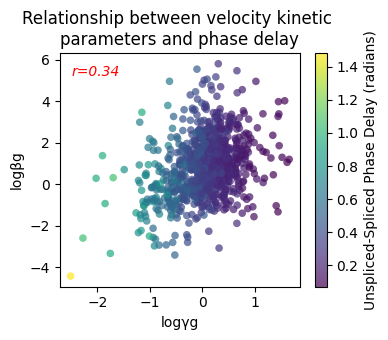

In [105]:
plt.figure(None, (4, 3.5))
ax = plt.subplot(1,1,1)
plt.scatter(velocity_fit1.log_gammas, 
            velocity_fit1.log_betas, 
            s=30, c=shift_obs, cmap='viridis', edgecolor='none', alpha=0.7, rasterized=True)
plt.xlabel("logγg")#, size=12, fontweight='bold')
plt.ylabel("logβg")#, size=12, fontweight='bold')
plt.colorbar(label="Unspliced-Spliced Phase Delay (radians)")
plt.tight_layout()
add_pearson_corr_text(velocity_fit1.log_gammas, velocity_fit1.log_betas, ax)
plt.title("Relationship between velocity kinetic \nparameters and phase delay")
plt.tight_layout()
plt.show()

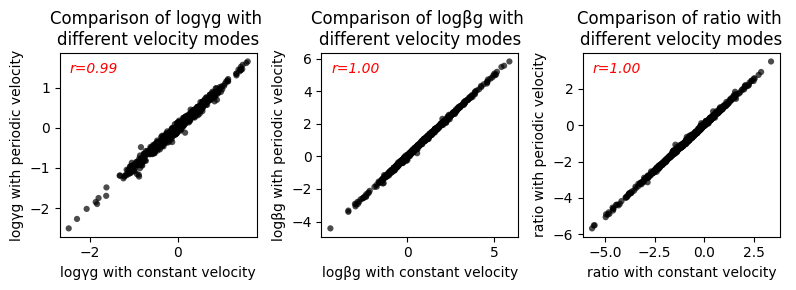

In [106]:
plt.figure(None, (8, 3))
ax1 = plt.subplot(1, 3, 1)
plt.scatter(velocity_fit0.log_gammas, 
            velocity_fit1.log_gammas, 
            s=20, c='black', alpha=0.7, edgecolor='none', rasterized=True)
plt.xlabel("logγg with constant velocity")#, size=12, fontweight='bold')
plt.ylabel("logγg with periodic velocity")#, size=12, fontweight='bold')
plt.title("Comparison of logγg with \ndifferent velocity modes")
add_pearson_corr_text(velocity_fit0.log_gammas, velocity_fit1.log_gammas, ax1)


ax2 = plt.subplot(1, 3, 2)
plt.scatter(velocity_fit0.log_betas, 
            velocity_fit1.log_betas, 
            s=20, c='black', alpha=0.7, edgecolor='none', rasterized=True)
plt.xlabel("logβg with constant velocity")#, size=12, fontweight='bold')
plt.ylabel("logβg with periodic velocity")#, size=12, fontweight='bold')
add_pearson_corr_text(velocity_fit0.log_betas, velocity_fit1.log_betas, ax2)
plt.title("Comparison of logβg with \ndifferent velocity modes")

ax3 = plt.subplot(1, 3, 3)
plt.scatter(velocity_fit0.log_gammas-velocity_fit0.log_betas, 
            velocity_fit0.log_gammas-velocity_fit1.log_betas, 
            s=20, c='black', alpha=0.7, edgecolor='none', rasterized=True)
plt.xlabel("ratio with constant velocity")#, size=12, fontweight='bold')
plt.ylabel("ratio with periodic velocity")#, size=12, fontweight='bold')
add_pearson_corr_text(velocity_fit0.log_gammas-velocity_fit0.log_betas, velocity_fit1.log_gammas-velocity_fit1.log_betas, ax3)
plt.title("Comparison of ratio with \ndifferent velocity modes")

plt.tight_layout()
plt.show()

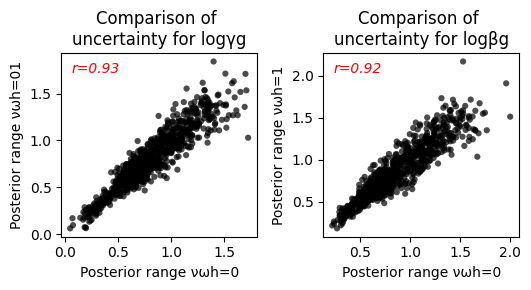

In [107]:
plt.figure(None, (5.5, 3))
ax1 = plt.subplot(1, 2, 1)
unc_gamma_0 = velocity_fit0.posterior["logγg"].squeeze().numpy().max(0) - velocity_fit0.posterior["logγg"].squeeze().numpy().min(0)
unc_gamma_1 = velocity_fit1.posterior["logγg"].squeeze().numpy().max(0) - velocity_fit1.posterior["logγg"].squeeze().numpy().min(0)
plt.scatter(unc_gamma_0, unc_gamma_1,  s=20, c='black', alpha=0.7, edgecolor='none', rasterized=True)
plt.xlabel("Posterior range νωh=0")#, size=12, fontweight='bold')
plt.ylabel("Posterior range νωh=01")#, size=12, fontweight='bold')
plt.title("Comparison of \nuncertainty for logγg")
add_pearson_corr_text(unc_gamma_0, unc_gamma_1, ax1)


ax2 = plt.subplot(1, 2, 2)
unc_beta_0 = velocity_fit0.posterior["logβg"].squeeze().numpy().max(0) - velocity_fit0.posterior["logβg"].squeeze().numpy().min(0)
unc_beta_1 = velocity_fit1.posterior["logβg"].squeeze().numpy().max(0) - velocity_fit1.posterior["logβg"].squeeze().numpy().min(0)
plt.scatter(unc_beta_0, unc_beta_1, s=20, c='black', alpha=0.7, edgecolor='none', rasterized=True)
plt.xlabel("Posterior range νωh=0")#, size=12, fontweight='bold')
plt.ylabel("Posterior range νωh=1")#, size=12, fontweight='bold')
add_pearson_corr_text(unc_beta_0, unc_beta_1, ax2)
plt.title("Comparison of \nuncertainty for logβg")

plt.tight_layout()
plt.show()

In [108]:
cycle_data_frame["gene"] = cycle_data_frame.index
cycle_data_frame.set_index('gene', inplace=True)

# Define the number of bins
num_bins = 20
bin_width = 2 * np.pi / num_bins

# Calculate the bin index for each gene
cycle_data_frame['bin_index'] = ((cycle_data_frame['peak_phase'] + 2 * np.pi) % (2 * np.pi) / bin_width).astype(int)

# Group genes by bin index and find top 10 genes in each bin
#top_genes_per_bin = cycle_data_frame.groupby('bin_index', group_keys=False).apply(lambda group: group.nlargest(10, 'amplitude'))

In [109]:
cycle_data_frame["shift_obs"] = shift_obs
cycle_data_frame["shift_obs_raw_data"] = shift_obs_raw_data

In [110]:
shifts_by_bin = []
shifts_by_bin_std = []
shifts_by_bin_raw = []
for i in range(0, num_bins):
    shifts_by_bin.append(np.mean(cycle_data_frame[cycle_data_frame['bin_index']==i]["shift_obs"]))
    shifts_by_bin_std.append(np.std(cycle_data_frame[cycle_data_frame['bin_index']==i]["shift_obs"]))
    shifts_by_bin_raw.append(np.mean(cycle_data_frame[cycle_data_frame['bin_index']==i]["shift_obs_raw_data"]))

shifts_by_bin = np.array(shifts_by_bin)
shifts_by_bin_std = np.array(shifts_by_bin_std)
shifts_by_bin_raw = np.array(shifts_by_bin_raw)

<Figure size 600x400 with 0 Axes>

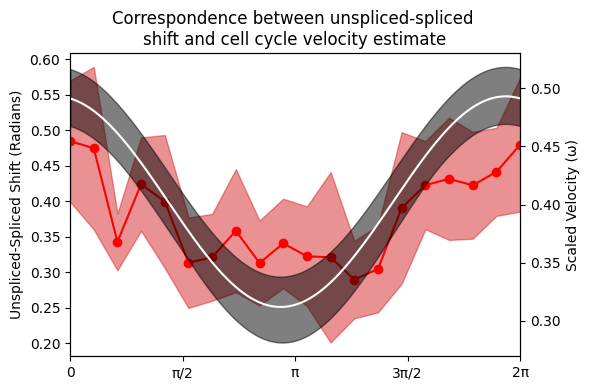

In [111]:
plt.figure(None, (6,4))
# Plot the line
# Create the first plot
fig, ax1 = plt.subplots(figsize=(6, 4))


ax1.plot(np.linspace(0, 2*np.pi, num_bins), shifts_by_bin, 'o-', label='Data', c='red')

# Plot the shaded region representing the standard deviation
ax1.fill_between(np.linspace(0, 2*np.pi, num_bins),
                 shifts_by_bin - shifts_by_bin_std / 2,
                 shifts_by_bin + shifts_by_bin_std / 2,
                 color='tab:red', alpha=0.5, label='Standard Deviation')
ax1.set_ylabel("Unspliced-Spliced Shift (Radians)")

full_pps_velo = velocity_fit1.posterior
omega = full_pps_velo["ω"].squeeze().numpy() / torch.exp(torch.mean(full_pps_velo["logγg"].squeeze().mean(0).detach())).numpy()
phi = velocity_fit1.phase_pyro.phis

# Create the second y-axis
ax2 = ax1.twinx()
sidx = np.argsort(phi)
ax2.plot(phi[sidx], omega.mean(0)[sidx], c='white')

tmp5 = np.percentile(omega[:, :], 0, axis=0)
tmp95 = np.percentile(omega[:, :], 100, axis=0)
ax2.fill_between(x=phi[sidx],
                 y1=tmp5[sidx], 
                 y2=tmp95[sidx], 
                 alpha=0.5, color="black")
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi],["0", "π/2", "π", "3π/2", "2π"])
#plt.ylim(0.2, 0.6)
plt.xlim(0, 2*np.pi)
plt.xlabel("VeloCycle Phase (ϕ)")
ax2.set_ylabel("Scaled Velocity (ω)")
plt.title("Correspondence between unspliced-spliced \nshift and cell cycle velocity estimate")

plt.tight_layout()
plt.show()

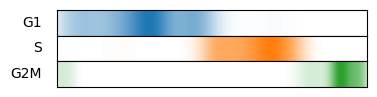

In [112]:
from statsmodels.nonparametric.kde import KDEUnivariate

def circular_kde(data, label=None, color=None):
    kde = KDEUnivariate(data)
    kde.fit(kernel='gau', bw='silverman', fft=False, cut=0, clip=[0, 2*np.pi])
    x = np.linspace(0, 2*np.pi, 1000)
    y = kde.evaluate(x)
    return x, y

# Sample data (replace these with your actual data)
phases = np.array(data_to_fit.obs["phase"])
phis = velocity_fit1.phase_pyro.phis.numpy()

# Create a mask for each category in phases
G1_mask = np.array(phases) == 'G1'
S_mask = np.array(phases) == 'S'
G2M_mask = np.array(phases) == 'G2M'

# Plot the circular kernel density distributions
g1_x, g1_y = circular_kde(np.array(phis)[G1_mask], label='G1', color='tab:blue')
s_x, s_y = circular_kde(np.array(phis)[S_mask], label='S', color='tab:blue')
g2m_x, g2m_y = circular_kde(np.array(phis)[G2M_mask], label='G2M', color='tab:blue')

# Custom colormap from white to "tab:blue"
from matplotlib.colors import LinearSegmentedColormap

# Custom colormaps
colors_blue = [(1, 1, 1), (0.1216, 0.4667, 0.7059)]  # white to tab:blue
colors_orange = [(1, 1, 1), (1, 0.498, 0.0549)]    # white to tab:orange
colors_green = [(1, 1, 1), (0.1725, 0.6275, 0.1725)]   # white to tab:green

cmap_blue = LinearSegmentedColormap.from_list("blue_diverge", colors_blue, N=100)
cmap_orange = LinearSegmentedColormap.from_list("orange_diverge", colors_orange, N=100)
cmap_green = LinearSegmentedColormap.from_list("green_diverge", colors_green, N=100)

fig = plt.figure(figsize=(4, 1))
fig.subplots_adjust(hspace=0)

ax1 = fig.add_subplot(3, 1, 1)
cax = ax1.imshow(g1_y.reshape(1, -1), cmap=cmap_blue, aspect='auto', extent=[0, 2*np.pi, 0, 1])
ax1.set_yticks([])
ax1.set_xticks([])
ax1.text(-0.05, 0.5, 'G1', va='center', ha='right', transform=ax1.transAxes)

ax2 = fig.add_subplot(3, 1, 2)
cax = ax2.imshow(s_y.reshape(1, -1), cmap=cmap_orange, aspect='auto', extent=[0, 2*np.pi, 0, 1])
ax2.set_yticks([])
ax2.set_xticks([])
ax2.text(-0.05, 0.5, 'S', va='center', ha='right', transform=ax2.transAxes)

ax3 = fig.add_subplot(3, 1, 3)
cax = ax3.imshow(g2m_y.reshape(1, -1), cmap=cmap_green, aspect='auto', extent=[0, 2*np.pi, 0, 1])
ax3.set_yticks([])
ax3.set_xticks([])
ax3.text(-0.05, 0.5, 'G2M', va='center', ha='right', transform=ax3.transAxes)

plt.show()

In [113]:
SPLICED_COLOR = "#227c9d"
UNSPLICED_COLOR = "#9f4a54"

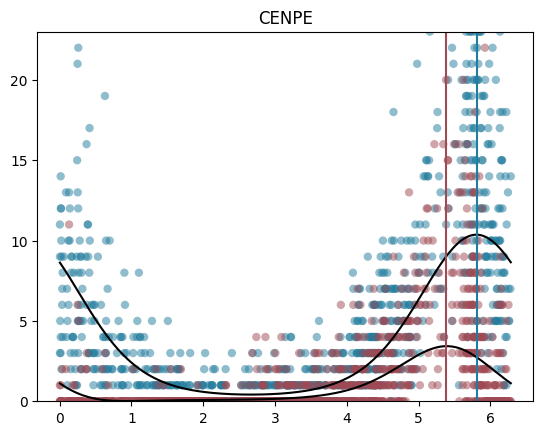

In [114]:
S = data_to_fit.layers["spliced"].toarray()
U = data_to_fit.layers["unspliced"].toarray()
ElogS = velocity_fit1.posterior["ElogS2"].T
ElogU = velocity_fit1.posterior["ElogU2"].T
gene = "CENPE"
gix = np.where(data_to_fit.var.index==gene)[0]
phis = velocity_fit1.phase_pyro.phis.numpy()
phis_order = np.argsort(phis)
plt.scatter(phis, S[:, gix], c=SPLICED_COLOR, edgecolor='none', alpha=0.5, rasterized=True)
plt.scatter(phis, U[:, gix], c=UNSPLICED_COLOR, edgecolor='none', alpha=0.5, rasterized=True)
plt.plot(phis[phis_order], np.exp(ElogS[:, gix])[phis_order], c='black')
plt.plot(phis[phis_order], np.exp(ElogU[:, gix])[phis_order], c='black')
plt.axvline(phis[np.argmax(ElogS[:, gix])], c=SPLICED_COLOR)
plt.axvline(phis[np.argmax(ElogU[:, gix])], c=UNSPLICED_COLOR)
plt.title(gene)
plt.ylim(0, np.percentile(S[:, gix], 95))
plt.show()

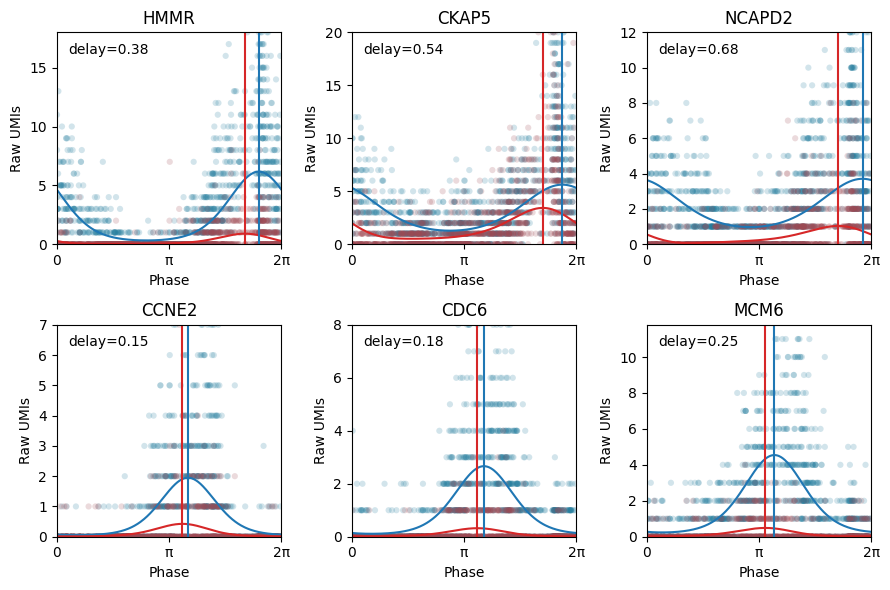

In [116]:
genes = ["HMMR", "CKAP5", "NCAPD2", "CCNE2", "CDC6", "MCM6"] 
fig, axes = plt.subplots(2, 3, figsize=(9, 6))

for ax, gene in zip(axes.ravel(), genes):
    gix = np.where(data_to_fit.var.index == gene)[0]
    phis_order = np.argsort(phis)
    ax.scatter(phis, S[:, gix], c=SPLICED_COLOR, s=20, edgecolor='none', alpha=0.2, rasterized=True)
    ax.scatter(phis, U[:, gix], c=UNSPLICED_COLOR, s=20, edgecolor='none', alpha=0.2, rasterized=True)
    ax.plot(phis[phis_order], np.exp(ElogS[:, gix])[phis_order], c="tab:blue")
    ax.plot(phis[phis_order], np.exp(ElogU[:, gix])[phis_order], c="tab:red")
    ax.axvline(phis[np.argmax(ElogS[:, gix])], c="tab:blue")
    ax.axvline(phis[np.argmax(ElogU[:, gix])], c="tab:red")
    ax.set_title(gene)
    ax.set_ylim(0, np.percentile(S[:, gix], 99))
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
    ax.set_xlabel("Phase")
    ax.set_ylabel("Raw UMIs")
    value_to_display = "delay="+str(phis[np.argmax(ElogS[:, gix])]-phis[np.argmax(ElogU[:, gix])])[:4] #phis[np.argmax(ElogU[:, gix])]  # Modify as needed
    ax.text(0.05, 0.95, str(value_to_display),
            transform=ax.transAxes, verticalalignment='top')
plt.tight_layout()
plt.show()

In [117]:
gamma_pps0 = velocity_fit0.posterior["logγg"].squeeze()
beta_pps0 = velocity_fit0.posterior["logβg"].squeeze()
omega_pps0 = velocity_fit0.posterior["ω"].squeeze()

In [118]:
gamma_pps1 = velocity_fit1.posterior["logγg"].squeeze()
beta_pps1 = velocity_fit1.posterior["logβg"].squeeze()
omega_pps1 = velocity_fit1.posterior["ω"].squeeze()

In [119]:
gamma_omega_uncertainty_corr0 = []
for ix in range(gamma_pps0.shape[1]):
    gamma_omega_uncertainty_corr0.append(np.corrcoef(gamma_pps0[:, ix], omega_pps0[:, ix])[0, 1])
gamma_omega_uncertainty_corr0 = np.array(gamma_omega_uncertainty_corr0)

In [120]:
phis = velocity_fit0.phase_pyro.phis
fit_ElogS2 = velocity_fit0.posterior["ElogS2"]
fit_ElogU2 = velocity_fit0.posterior["ElogU2"]
shift_obs0 = pycircstat.cdiff(phis[np.argmax(fit_ElogS2.numpy().T, axis=0)], phis[np.argmax(fit_ElogU2.numpy().T, axis=0)])

In [122]:
cycle_data_frame["gene"] = cycle_data_frame.index
cycle_data_frame.set_index('gene', inplace=True)

# Define the number of bins
num_bins = 20
bin_width = 2 * np.pi / num_bins

# Calculate the bin index for each gene
cycle_data_frame['bin_index'] = ((cycle_data_frame['peak_phase'] + 2 * np.pi) % (2 * np.pi) / bin_width).astype(int)

# Group genes by bin index and find top 10 genes in each bin
#top_genes_per_bin = cycle_data_frame.groupby('bin_index', group_keys=False).apply(lambda group: group.nlargest(10, 'amplitude'))

cycle_data_frame["uncertainty_corr"] = gamma_omega_uncertainty_corr0

shifts_by_bin = []
shifts_by_bin_std = []
shifts_by_bin_raw = []
for i in range(0, num_bins):
    shifts_by_bin.append(np.mean(cycle_data_frame[cycle_data_frame['bin_index']==i]["uncertainty_corr"]))
    shifts_by_bin_std.append(np.std(cycle_data_frame[cycle_data_frame['bin_index']==i]["uncertainty_corr"]))

shifts_by_bin = np.array(shifts_by_bin)
shifts_by_bin_std = np.array(shifts_by_bin_std)

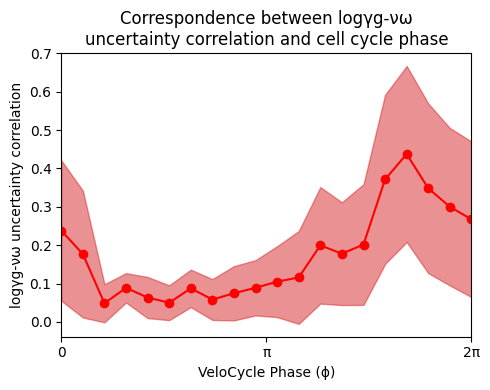

In [123]:
fig, ax1 = plt.subplots(figsize=(5, 4))


ax1.plot(np.linspace(0, 2*np.pi, num_bins), shifts_by_bin, 'o-', label='Data', c='red')

# Plot the shaded region representing the standard deviation
ax1.fill_between(np.linspace(0, 2*np.pi, num_bins),
                 shifts_by_bin - shifts_by_bin_std / 2,
                 shifts_by_bin + shifts_by_bin_std / 2,
                 color='tab:red', alpha=0.5, label='Standard Deviation')
ax1.set_ylabel("logγg-νω uncertainty correlation")

plt.xlim(0, 2*np.pi)
plt.xticks([0, np.pi, 2*np.pi],["0", "π", "2π"])
plt.xlabel("VeloCycle Phase (ϕ)")
plt.title("Correspondence between logγg-νω\nuncertainty correlation and cell cycle phase")

plt.tight_layout()
plt.show()